In [1]:
%matplotlib inline

In [2]:
import argparse
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from torch.utils.data import Dataset, DataLoader
import pandas as pd

PyTorch Version:  1.7.0
Torchvision Version:  0.8.0a0


In [3]:
import open3d 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
%run cnet.py

In [17]:
if torch.cuda.device_count()>1:
    device = torch.device('cuda:0')
elif torch.cuda.device_count()==1:
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')
print(device)

cuda:0


In [18]:
parser = argparse.ArgumentParser()

parser.add_argument('-bs', '--batch_size', type=int, default=4)
parser.add_argument('-epoch', type=int, default=8)
parser.add_argument('-bn', type=int, default=8)
parser.add_argument('-lr', type=float, default=5e-5)

opt = parser.parse_args()

usage: __main__.py [-h] [-bs BATCH_SIZE] [-epoch EPOCH] [-bn BN] [-lr LR]
__main__.py: error: unrecognized arguments: -f /p/home/jusers/cherepashkin1/jureca/.local/share/jupyter/runtime/kernel-785ae9d4-369f-401d-a8c8-d8a89e7b8649.json


SystemExit: 2

/p/software/jurecadc/stages/2020/software/Python/3.8.5-GCCcore-9.3.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

#number of spherical harmonics amplituds to regress
ampl = 16

# Number of classes in the dataset
num_classes = ampl

#downsample ply, taking point every ds steps
ds = 10

Helper Functions - train_model
----------------




In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    
#    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    lossar = np.zeros([2,num_epochs])
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            rloss = 0.0
            
            # Iterate over data.
            for i_batch, sample_batched in enumerate(dataloaders[phase]):
#                 print(len(dataloaders[phase]))
                if i_batch == bn:
                    break
                inputs = sample_batched['image']
                labels = sample_batched['landmarks']
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
#                         print(inputs.shape)
#                         F = torch.sum(torch.mul(inputs,inputs), axis = 0)
#                         print(F.shape)
#                         x = torch.zeros([8, 1161, 3])
                        x = inputs
                        y = torch.zeros([x.shape[0], x.shape[1]])
                        y = y.to(device)
                        for i in range(x.shape[0]):
                            y[i,:] = torch.sqrt(x[i,:,0]*x[i,:,0]+x[i,:,1]*x[i,:,1]+x[i,:,2]*x[i,:,2])
                        y = torch.unsqueeze(y,2)
#                         y = torch.unsqueeze(y,1)
#                         print(y.shape)
                        outputs = model(y)


                        # self-supervised part
                        
                        loss = criterion(outputs, labels)
#                         F = torch.matmul(outputs,Y_N2)
#                         loss = criterion(, inputs)
                        #loss = my_loss(outputs,labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                rloss += loss.item()
#                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if bn < len(dataloaders[phase].dataset):
                ebn = bn
            else:
                ebn = len(dataloaders[phase].dataset)
            if phase == 'train':
                lossar[0][epoch] = rloss/ebn
            else: 
                lossar[1][epoch] = rloss/ebn          
#            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.6f}'.format(phase, rloss/ebn))
#            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))

            # deep copy the model
#            if phase == 'val' and epoch_acc > best_acc:
#                best_acc = epoch_acc
#            best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)
            val_acc_history = []

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
#    model.load_state_dict(best_model_wts)
    return model, lossar

# Initialize and Reshape the Networks

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size



Load Data
---------





In [22]:
class Seed3D_Dataset(Dataset):
    """seed point cloud dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(os.path.join(root_dir,'F_N_1001.csv'))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
#        img = np.zeros([40000, 3, 1])
        rd = self.root_dir.replace('598test','598_processing')
        img_name = \
        os.path.join(rd,\
                     self.landmarks_frame.iloc[idx, 0]+'_Surface.ply').replace('\\','/')
        pcd = open3d.io.read_point_cloud(img_name)
        img = np.asarray(pcd.points)
#         img = np.genfromtxt(img_name, skip_header = 7, skip_footer = 1)
        img = np.concatenate((img, np.zeros([58014-img.shape[0],3])), axis=0)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 441)
        sample = {'image': img, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [23]:
img_name = '/p/home/jusers/cherepashkin1/jureca/cherepashkin1/598_processing/train/1484727/1493241_Surface.ply'
pcd = open3d.io.read_point_cloud(img_name)
img = np.asarray(pcd.points)
img = np.concatenate((img, np.zeros([58014-img.shape[0],3])), axis=0)
ctr = np.mean(img,axis = 0)
ctr.shape
image = img - np.mean(img,axis = 0)

In [24]:
img.shape

(58014, 3)

In [25]:
from numpy import linalg as LA

In [26]:
class AmpCrop(object):
    """Crop the label, spherical harmonics amplitude."""
    def __init__(self, ampl):
        self.ampl = ampl
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': image,
                'landmarks': landmarks[:,:self.ampl]}
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, device):
#        assert isinstance(device, str)
        self.device = device
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        landmarks = np.squeeze(landmarks)
        return {'image': torch.Tensor(image).to(self.device),
                'landmarks': torch.Tensor(landmarks).to(self.device)}
class Minmax3Dimage(object):
    """Normalize 3D input data to be laying in [0,1]"""
    def __init__(self,minmax):
        minf = minmax[0]
        maxf = minmax[1]
        self.minf = minf
        self.maxf = maxf
#        assert isinstance(device, str)
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = (image-self.minf)/(self.maxf-self.minf)
        #         for i in range(3):
#             image[:,i] = (image[:,i]-np.min(image,axis=0)[i])/\
#             (np.max(image,axis=0)[i]-np.min(image,axis=0)[i])
        return {'image': image,
                'landmarks': landmarks}

class Downsample(object):
    """Downsample the input ply file."""
    def __init__(self, ds):
        #assert isinstance(output_size, (int, tuple))
        self.ds = ds
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        ds_image = image[::self.ds,:]
        return {'image': ds_image,
                'landmarks': landmarks}
class Shuffleinput(object):
    """Shuffle the rows of input ply file."""
    def __init__(self, shuffle_seed):
        #assert isinstance(output_size, (int, tuple))
        self.shuffle_seed = shuffle_seed
    def __call__(self, sample):
        np.random.seed(self.shuffle_seed)
        image, landmarks = sample['image'], sample['landmarks']
        np.random.shuffle(image) 
        return {'image': image,
                'landmarks': landmarks}
class Minmax(object):
    """Normalize the input data to lay in [0,1]."""
    def __init__(self, tmean):
#        assert isinstance(tmean, numpy.ndarray)
        self.tmean = tmean
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
#        print(type(landmarks))
#        print(type(self.tmean[3]))
#        landmarks = (landmarks - self.tmean[2])/(self.tmean[3]-self.tmean[2])
        landmarks = (landmarks - np.min(self.tmean[2]))/(np.max(self.tmean[3])-np.min(self.tmean[2]))
        
        return {'image': image,
                'landmarks': landmarks}
class Reshape(object):
    """Normalize the input data to lay in [0,1]."""
    def __init__(self, input_layer):
#        assert isinstance(tmean, numpy.ndarray)
        self.input_layer = input_layer
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
#        print(type(landmarks))
#        print(type(self.tmean[3]))
        padval = self.input_layer**2-image.shape[0]
        if padval >= 0:
            image = np.pad(image, ((0,padval),(0,0)), mode='constant')
        else: 
            image = image[:self.input_layer**2]
        image = np.reshape(image, [3,self.input_layer,self.input_layer])
#        landmarks = (landmarks - self.tmean[2])/(self.tmean[3]-self.tmean[2]) 
        return {'image': image,
                'landmarks': landmarks}
class Normalize(object):
    """Normalize the input data to lay in [0,1]."""
    def __init__(self):
#        assert isinstance(tmean, numpy.ndarray)
        a = 1
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
#        print(type(landmarks))
#        print(type(self.tmean[3]))
        X = image[:,0]
        Y = image[:,1]
        Z = image[:,2]
        C = np.zeros([3,3])
        C[0,0] = np.matmul(X,X.transpose())
        C[0,1] = np.matmul(X,Y.transpose())
        C[0,2] = np.matmul(X,Z.transpose())
        C[1,0] = C[0,1]
        C[1,1] = np.matmul(Y,Y.transpose())
        C[1,2] = np.matmul(Y,Z.transpose())
        C[2,0] = C[0,2]
        C[2,1] = C[1,2]
        C[2,2] = np.matmul(Z,Z.transpose())
        w,v = LA.eig(C)
        image = np.matmul(v.transpose(),image.transpose()).transpose()
        return {'image': image,
                'landmarks': landmarks}

In [27]:
def getsize(new_hi,ker,srd): 
    pad = (0,0)
    dil = np.asarray((1,1))
    return(tuple((np.squeeze((np.asarray(new_hi)+\
    2*np.asarray(pad)-dil*[np.asarray(ker)-1]+1)/\
                             np.asarray(srd))).astype(int)))
class TNet(nn.Module):
    def __init__(self) :
        super().__init__()
#         new_h, ampl, m_kernel, m_stride, hidden_dim, C_in, ratio = \
#         tuple(tupa[i] for i in list(range(6, 10))+[11,16,17])
        new_h = 58014
        ampl = 9
        m_kernel = 1
        m_stride = 1
        hidden_dim = 20
        C_in = 1
        new_w = 3
        self.pool = nn.MaxPool2d(m_kernel,m_stride)
        idt = tuple(map(lambda x: x, \
                getsize((new_h,new_w,m_kernel,m_stride))))
        input_dim = idt[0]*idt[1]*C_in
#        print(idt)
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for hdim in hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, ampl))
        
    def forward(self, x):
#        print('start',x.shape)
        x = self.pool(x)
#        print('view',x.shape)
        x = x.view(x.shape[0],-1)
        for layer in self.layers[:-1]:
#            print(x.shape)
            x = F.leaky_relu(layer(x))
        out = F.softmax(self.layers[-1](x))
        return out  
nnarchitectures = {'TNet':TNet}


In [28]:
%run cnet.py

In [29]:
class CNet(torch.nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
#         C_in = 1
#         D_out = 9
        hn1 = int(1e4)
        hn2 = int(1e4)
        hn3 = int(1e4)
        hn4 = int(1e4)
        hn5 = int(1e4)
        hn6 = int(1e4)
        hn7 = int(1e4)
        self.conv0 = nn.Conv2d(1, 25, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(25, 25, 1)
        self.conv2 = nn.Conv2d(25, 5, 1)
        self.linear1 = torch.nn.Linear(58015, hn1)
        self.linear2 = torch.nn.Linear(hn1, hn2)
        self.linear3 = torch.nn.Linear(hn2, hn3)
        self.linear4 = torch.nn.Linear(hn3, hn4)
        self.linear5 = torch.nn.Linear(hn4, hn5)
        self.linear6 = torch.nn.Linear(hn5, hn6)
        self.linear7 = torch.nn.Linear(hn6, hn7)
        self.linear8 = torch.nn.Linear(hn7, 441)

#         self.conv1 = nn.Conv2d(6, 16, 5)

#         self.linear0 = torch.nn.Linear(290000, 441)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
#         print(x.shape)
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
#         print(t.mean(x))
#         x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.shape[0], -1)
#         x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
#         print(x.shape)
#     16, 464112
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        x = self.linear6(x)
        x = self.linear7(x)
        x = self.linear8(x)
#         x = F.relu(self.linear0(x))
#         x = F.relu(self.linear1(x))
        #x = self.linear1(x)
        return x
# class FCL(torch.nn.Module):
#     def __init__(self,ampl):

#     def forward(self, x):
#         x = x.view(x.shape[0], -1)
#         x = self.linear1(x)
#         x = self.linear2(x)
#         x = self.linear3(x)
#         x = self.linear4(x)
#         return x

In [30]:
# -*- coding: utf-8 -*-
#
# Developed by Haozhe Xie <cshzxie@gmail.com>
#
# References:
# - https://github.com/shawnxu1318/MVCNN-Multi-View-Convolutional-Neural-Networks/blob/master/mvcnn.py

# import torch
# import torchvision.models


class Encoder(torch.nn.Module):
    # Pix2Vox
    def __init__(self, cfg):
        super(Encoder, self).__init__()
        self.cfg = cfg

        # Layer Definition
        vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(vgg16_bn.features.children()))[:27]
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=3)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, kernel_size=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ELU()
        )

        # Don't update params in VGG16
        for param in vgg16_bn.parameters():
            param.requires_grad = False

    def forward(self, rendering_images):
        # print(rendering_images.size())  # torch.Size([batch_size, n_views, img_c, img_h, img_w])
        rendering_images = rendering_images.permute(1, 0, 2, 3, 4).contiguous()
        rendering_images = torch.split(rendering_images, 1, dim=0)
        image_features = []

        for img in rendering_images:
            features = self.vgg(img.squeeze(dim=0))
            # print(features.size())    # torch.Size([batch_size, 512, 28, 28])
            features = self.layer1(features)
            # print(features.size())    # torch.Size([batch_size, 512, 26, 26])
            features = self.layer2(features)
            # print(features.size())    # torch.Size([batch_size, 512, 24, 24])
            features = self.layer3(features)
            # print(features.size())    # torch.Size([batch_size, 256, 8, 8])
            image_features.append(features)

        image_features = torch.stack(image_features).permute(1, 0, 2, 3, 4).contiguous()
        # print(image_features.size())  # torch.Size([batch_size, n_views, 256, 8, 8])
        return image_features


## FCL

In [31]:
%run 

Exception: you must provide at least a filename.

In [32]:
class FCL(torch.nn.Module):
    def __init__(self,ampl):
        super().__init__()
        hn1 = int(1e4)
        hn2 = int(1e4)
        hn3 = int(1e4)
        self.linear1 = torch.nn.Linear(1161, hn1)
        self.linear2 = torch.nn.Linear(hn1, hn2)
        self.linear3 = torch.nn.Linear(hn2, hn3)
        self.linear4 = torch.nn.Linear(hn3, ampl)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
#         print(x.shape)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

In [33]:
class TNet(nn.Module):
    def __init__(self) :
        super().__init__()
#         self.pool = nn.MaxPool2d(m_kernel,m_stride)
#         idt = tuple(map(lambda x: x, \
#                 getsize((new_h, int(new_h*ratio)),m_kernel,m_stride)))
        input_dim = 1161
        ampl = 441
        rep = '(np.repeat(1024, 10),512)'
        hidar = {rep : (np.repeat(1024, 10),512)}
        hidden_dim = np.hstack(hidar[rep])
#        print(idt)
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for hdim in hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, ampl))
        
    def forward(self, x):
#        print('start',x.shape)
#         x = self.pool(x)
#        print('view',x.shape)
        x = x.view(x.shape[0],-1)
#         print(x.shape)
        for layer in self.layers[:-1]:
#            print(x.shape)
            x = F.leaky_relu(layer(x))
        out = F.softmax(self.layers[-1](x))
        return out  
nnarchitectures = {'TNet':TNet}

In [34]:
ampl = 16
batch_size = 1200
data_dir = 'D:/seva/598test'
data_dir = '/p/home/jusers/cherepashkin1/jureca/cherepashkin1/598test'
model_name = "densenet"
ds = 5


In [41]:
data_transforms = {'train': transforms.Compose([
#             AmpCrop(ampl),\
#             Minmax(tmean[:,:ampl]),\
            Minmax3Dimage((0.60117054538415,110.972068294924)),\
           Downsample(ds),\
#           Shuffleinput(0),\
#             Normalize(),\
#             Reshape(224),\
            ToTensor(device)
    ]),
    'val': transforms.Compose([
#             AmpCrop(ampl),\
#             Minmax(tmean[:,:ampl]),\
            Minmax3Dimage((0.60117054538415,110.972068294924)),\
           Downsample(ds),\
#           Shuffleinput(0),\
#             Normalize(),\
#             Reshape(224),\
            ToTensor(device)
    ]),
}

In [42]:

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: Seed3D_Dataset(root_dir=os.path.join(data_dir,x), \
                                    transform=data_transforms[x]) 
                  for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# dataset = Seed3D_Dataset(csv_file=mainpath+'/sh_paramters.csv', root_dir=data_dir, transform=data_transform)
# dataloader = DataLoader(dataset, bs,
#                         shuffle=False, num_workers=0)

Initializing Datasets and Dataloaders...


Create the Optimizer
--------------------





In [43]:
# # Send the model to GPU
# model_ft = model_ft.to(device)

# # Gather the parameters to be optimized/updated in this run. If we are
# #  finetuning we will be updating all parameters. However, if we are 
# #  doing feature extract method, we will only update the parameters
# #  that we have just initialized, i.e. the parameters with requires_grad
# #  is True.
# params_to_update = model_ft.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Run Training and Validation Step
--------------------------------





In [48]:
# Setup the loss fxn
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(reduction='mean')
bn = 1
num_epochs = 1
# model_name = 'densenet'
lossar = np.zeros([2,num_epochs])
#scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
#for i,lr in enumerate([0.0001, 0.0005, 0.001, 0.005]):
num_classes = 441
ampl = num_classes
# smodel, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
# Train and evaluate
#smodel = FCL(ampl)
#smodel = TNet()
smodel = None
smodel = Encoder()
#smodel = nn.DataParallel(smodel)
smodel.cuda()
lr=5e-5

TypeError: __init__() missing 1 required positional argument: 'cfg'

In [47]:
scratch_optimizer = torch.optim.Adam(smodel.parameters(), \
            lr, betas=(0.9, 0.999),\
            eps=1e-08, weight_decay=0, \
            amsgrad=False)
model, lossar = train_model(smodel, dataloaders_dict, criterion, scratch_optimizer, num_epochs, is_inception=(model_name=="inception"))

Epoch 0/0
----------
train Loss: 34.809910
val Loss: 32.104568

Training complete in 2m 18s


In [ ]:
s = print(smodel)

In [ ]:
import sys
with open('filename.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(smodel)
    sys.stdout = original_stdout # Reset the standard output to its original value

In [ ]:
dirname = '/p/home/jusers/cherepashkin1/jureca/cherepashkin1/598test/plot_output/'+str(int(time.time()))+'/'
os.mkdir(dirname)
np.save(dirname+'lossar.npy',lossar)

<ipython-input-21-07f5b5e4feca>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes.set_xticks(np.arange(0, int(num_epochs*1.1)),\


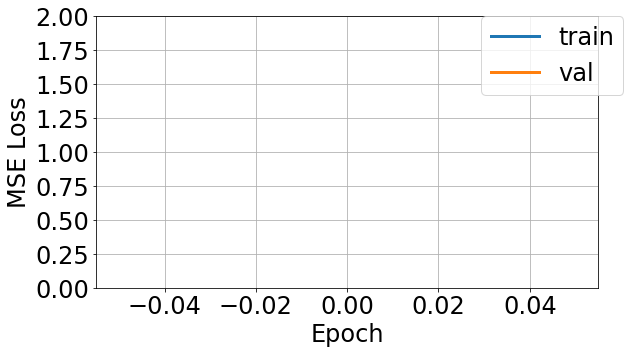

In [21]:
plt.rcParams["figure.figsize"] = (9,5)
fig = plt.figure()
axes = plt.gca()
# ymin, ymax = , 2
# axes.set_ylim([ymin,ymax])
labels_text = ['train', 'val']
for i in range(2):
    plt.plot(np.arange(lossar.shape[1]),lossar[i,:],label=labels_text[i],linewidth=3)
axes.set_xticks(np.arange(0, int(num_epochs*1.1)),\
                          max(int(num_epochs*0.1),1))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., \
           fontsize = 24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.autoscale(enable=True, axis='both', tight=None)
# ymin, ymax = -, 2
# axes.set_ylim([ymin,ymax])
ymin, ymax = 0,2
axes.set_ylim([ymin,ymax])
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('MSE Loss', fontsize=24)
plt.savefig(dirname+\
#                     'num_ampl='+str(ampl)+\
                'bn'+str(bn)+\
                'bs'+str(batch_size)+\
                'ds'+str(ds)+\
                'epochs'+str(num_epochs)+\
                'lr'+str(lr)+\
                't'+str(time.time())+\
            '.png', bbox_inches='tight')

## Return SH coefficient vector from the trained model

In [22]:
phase = 'val'
bn = 1
ampl = 441
dataloaders = dataloaders_dict
for i_batch, sample_batched in enumerate(dataloaders[phase]):
    if i_batch == bn:
        break
    inputs = sample_batched['image']
    x = inputs
    y = torch.zeros([x.shape[0], x.shape[1]])
    y = y.to(device)
    for i in range(x.shape[0]):
        y[i,:] = torch.sqrt(x[i,:,0]*x[i,:,0]+x[i,:,1]*x[i,:,1]+x[i,:,2]*x[i,:,2])
    gt = sample_batched['landmarks']
    y = torch.unsqueeze(y,2)
    o = model(y)

#    print(model(inputs).shape)
#    output = np.multiply(model(inputs).detach().cpu().numpy(),tmean[3,:ampl]-tmean[2,:ampl])+tmean[2,:ampl]
#    real_output = np.multiply(gt.detach().cpu().numpy(),tmean[3,:ampl]-tmean[2,:ampl])+tmean[2,:ampl]
#     print(output[0])
#     print(real_output[0])

In [23]:
o = o.detach().cpu().numpy()
gt = gt.detach().cpu().numpy()

In [24]:
np.savetxt(dirname+'o[0]', o[0], delimiter = ',')

In [25]:
plt.rc('text', usetex=True)

# Grids of polar and azimuthal angles
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)
#r = np.linspace(-1, 1, 100)
# Create a 2-D meshgrid of (theta, phi) angles.
theta, phi = np.meshgrid(theta, phi)
# Calculate the Cartesian coordinates of each point in the mesh.
xyz = np.array([np.sin(theta) * np.sin(phi),
                np.sin(theta) * np.cos(phi),
                np.cos(theta)])

In [26]:
from scipy.special import sph_harm

(100, 100)


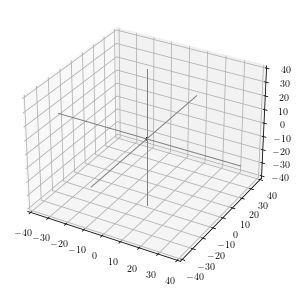

In [27]:

#coef = np.random.rand(10,10)

def plot_Y(ax, coef):
    """Plot the spherical harmonic of degree el and order m on Axes ax."""
    f = np.zeros([100,100]).astype('complex128')
    for l in range(int(np.sqrt(len(coef)))):
        for m in range(-l,l+1):
            fb = coef[l*(l+1)+m] * sph_harm(abs(m), l, phi, theta)
            f += fb
    Yx, Yy, Yz = np.abs(f) * xyz
    cmap = plt.cm.ScalarMappable(cmap=plt.get_cmap('PRGn'))
    cmap.set_clim(-0.5, 0.5)

    ax.plot_surface(Yx, Yy, Yz,
                    facecolors=cmap.to_rgba(f.real),
                    rstride=2, cstride=2)
    print(Yz.shape)
    # Draw a set of x, y, z axes for reference.
    ax_lim = 50
    ax.plot([-ax_lim, ax_lim], [0,0], [0,0], c='0.5', lw=1, zorder=10)
    ax.plot([0,0], [-ax_lim, ax_lim], [0,0], c='0.5', lw=1, zorder=10)
    ax.plot([0,0], [0,0], [-ax_lim, ax_lim], c='0.5', lw=1, zorder=10)
    # Set the Axes limits and title, turn off the Axes frame.
#    ax.set_title(r'$Y_{{{},{}}}$'.format(el, m))
    ax_lim = 40
    ax.set_xlim(-ax_lim, ax_lim)
    ax.set_ylim(-ax_lim, ax_lim)
    ax.set_zlim(-ax_lim, ax_lim)
    ax.axis('on')
    return(Yx, Yy, Yz)
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(projection='3d')
#l, m = 2, 0
# coef = [116.40520943, -4.51331063,  -1.22070776, 2.53049672, 1.25615844,\
#    1.59720443,  28.4781262,   -0.33878004,  -4.02484515]
Yx, Yy, Yz = plot_Y(ax, o[0])
#plot_Y(ax,6,3)
#plt.savefig('Y{}_{}.png'.format(l, m))
#plt.show()
plt.savefig(dirname+'surface')

In [30]:
file = open(dirname+"job-parameters.txt", "w") 
file.write('epoch='+str(opt.epoch)+'\n'\
            'bn='+str(opt.bn)+'/n'\
            'bs='+str(opt.bs)+'/n'\
            'lr='+str(opt.lr)+'/n'\
          ) 
file.close() 

NameError: name 'opt' is not defined